<a href="https://colab.research.google.com/github/gpenessot/OCT23_BDS_Radios_Poumons/blob/main/4_Transfer_learning_%26_hyperparameter_tuning_VGG19_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projet DST - Etape 4 Modélisation - Transfer learning avec réentrainement

Notebook adapté du notebook commun "baseline - hyperparameter tuning"

## 1) Montage Drive & import librairies : à faire à chaque ouverture

In [ ]:
# Connection du notebook au google drive perso

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Installation du keras tuner dans l'environnement du notebook car pas installé par défaut

!pip install keras-tuner -q
import keras_tuner
from keras_tuner.tuners import  Hyperband

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 3.5 MB/s eta 0:00:00


In [ ]:
# Import des packages / librairies / fonctions nécessaires

import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import cv2
import zipfile
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam



from keras.callbacks import EarlyStopping

#Ajouts Thibaut :
import pickle #pour sauvegarde de l'historique d'entraînement
import os
import pandas as pd
#pour le Grad-CAM
from IPython.display import Image, display
import matplotlib
import matplotlib.cm as cm

## 2) Dézippage sets d'images : fait 1 fois

In [ ]:
# Dézippage des sets d'images (stockés sur google drive) dans l'environnement du notebook

# Dézippage train set
!unzip -q '/content/drive/MyDrive/Colab/TrainTest3.zip'

## 3) Import des datasets

In [ ]:
#A MODIFIER PAR L'UTILISATEUR : Paramétrage des dossiers locaux pour les datasets et les sauvegardes :

# Chemin du dossier TRAIN dézippé : à adapter si stocké ailleurs
dossier_train = "/content/Train/"

# Chemin du dossier TEST dézippé : à adapter si stocké ailleurs
dossier_test = "/content/Test"

#Dossier de sauvegarde du modèle au format.keras et de l'historique d'entraînement au format pickle
dossier_sauv = "/content"

#Nom du dataset (arbitraire), pour intégrer dans le nom de la sauvegarde et s'y retrouver plus facilement
#N'a pas de rapport avec le nom du dossier
nom_dataset = "TrainTest"

In [ ]:
# Affichage du lien du répertoire du set d'entrainement
train_set_dir = pathlib.Path(dossier_train).with_suffix('')

# Vérification nombre d'images dans le set d'entrainement
print ("Répertoire train set : ", train_set_dir)
train_set_image_count = len(list(train_set_dir.glob('*/*.png')))
print("Nombre images train set ", train_set_image_count)

print ("\n")

# Affichage du lien du répertoire du set de test
test_set_dir = pathlib.Path(dossier_test).with_suffix('')

# Vérification nombre d'images dans le set de test
print ("Répertoire test set : ", test_set_dir)
test_set_image_count = len(list(test_set_dir.glob('*/*.png')))
print("Nombre images test set ", test_set_image_count)

Répertoire train set :  /content/Train
Nombre images train set  3228


Répertoire test set :  /content/Test
Nombre images test set  807


## 3) Paramètres globaux

In [ ]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
MODE = 'rgb'   # rgb or grayscale

AUGMENTATION_ON = False

NUM_EPOCHS = 50
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2
L_RATE = 0.0001

NAME_TO_SAVE = "Resnet152v2_frozen2.0_unfrozen61.1"
NAME_TO_LOAD = "/content/drive/MyDrive/Colab/Model/Resnet152v2_frozen2.0_unfrozen21.1"

keras_tuner_logs_dir = "keras_tuner/logs"

CALLBACKS = [
    tf.keras.callbacks.ModelCheckpoint(NAME_TO_SAVE+'.weights.h5', save_best_only=True,save_weights_only=True, monitor="val_accuracy"),
    tf.keras.callbacks.ReduceLROnPlateau( monitor="val_accuracy", factor=0.2, patience=6, min_lr=0.000000001),
    tf.keras.callbacks.TensorBoard('keras_tuner/log')]

In [ ]:
# Création des sets d'entrainement et de validation au format keras
# Attention : modèles de transfer learning requièrent du RGB en input

# Création du set d'entrainement
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
  train_set_dir,
  validation_split=VALIDATION_SPLIT,
  subset="both",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  color_mode=MODE,
 # color_mode = "rgb", #pour les modèles de transfer_learning
  batch_size=BATCH_SIZE,
  label_mode= 'categorical')


# Création du set de validation
test_ds = tf.keras.utils.image_dataset_from_directory(
  train_set_dir,
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  color_mode=MODE,
#  color_mode = "rgb", #pour les modèles de transfer_learning
  batch_size=BATCH_SIZE,
  label_mode= 'categorical')

    #Configure dataset for performance with CACHE (not loading images at each epoch)
    #and PREFETCH (overlapping data processing and model execution)



Found 3228 files belonging to 3 classes.
Using 2583 files for training.
Using 645 files for validation.
Found 3228 files belonging to 3 classes.


## 4) Transfer learning sans tuning

### Import d'un modèle pré-entraîné pour le transfer learning

In [ ]:
#Import du modèle pré-entraîné et des poids sur un jeu de données
from tensorflow.keras.applications.resnet_v2 import ResNet152V2, preprocess_input, decode_predictions



#Appliquer le preprocessing sur les inputs ("Note: each Keras Application expects a specific kind of input preprocessing. resnet_v2.preprocess_input will scale input pixels between -1 and 1
#La fonction preprocess_input est dépendante du modèle choisi (à importer avec le modèle en début de cellule)
def preprocess(images, labels):
  return preprocess_input(images), labels

train_ds = train_ds.map(preprocess)
val_ds = val_ds.map(preprocess)
test_ds = test_ds.map(preprocess)
#Attention, le préprocess réécrit sur train_ds et val_ds, il faut donc le réimporter si on change de modèle




In [ ]:


model = keras.models.load_model(NAME_TO_LOAD + '.keras')


model.load_weights(NAME_TO_LOAD + '.weights.h5')

for layer in model.layers[2].layers[:-61]:
    layer.trainable = False

model._name = NAME_TO_SAVE



### Compilation et entraînement

In [ ]:
#Compilation
model.compile(optimizer=keras.optimizers.Adam(learning_rate=L_RATE),
              loss='categorical_crossentropy',
              metrics=[keras.metrics.CategoricalAccuracy(name ='accuracy')])
model.summary()

Model: "Resnet152v2_frozen2.0_unfrozen61.1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 resnet152v2 (Functional)    (None, None, None, 2048   58331648  
                             )                                   
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 dense_8 (Dense)             (None, 128)               12845184  
                                                                 
 dense_9 (Dense)             (None, 32)                4128      
                                

In [ ]:
# Définition d'une callback qui stoppe le processus d'entrainement quand une valeur monitorée
# (ici la validation loss) stagne pendant un certain nombre d'epochs (et ce à partir d'un certain nombre d'epochs)

CALLBACKS = [
    tf.keras.callbacks.ModelCheckpoint(NAME_TO_SAVE+'.weights.h5', save_best_only=True,save_weights_only=True, monitor="val_loss"),
    tf.keras.callbacks.ReduceLROnPlateau( monitor="val_loss", factor=0.2, patience=6, min_lr=0.000000001),
    tf.keras.callbacks.TensorBoard("keras_tuner/logs")]

In [ ]:
#Entraînement
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS,
                    callbacks = CALLBACKS )


Epoch 1/50
81/81 [==============================] - 27s 177ms/step - loss: 0.3618 - accuracy: 0.8118 - val_loss: 0.4324 - val_accuracy: 0.8341 - lr: 1.0000e-04
Epoch 2/50
81/81 [==============================] - 11s 138ms/step - loss: 0.3268 - accuracy: 0.8300 - val_loss: 0.4427 - val_accuracy: 0.8357 - lr: 1.0000e-04
Epoch 3/50
81/81 [==============================] - 8s 104ms/step - loss: 0.3055 - accuracy: 0.8374 - val_loss: 0.4458 - val_accuracy: 0.8326 - lr: 1.0000e-04
Epoch 4/50
81/81 [==============================] - 8s 104ms/step - loss: 0.3037 - accuracy: 0.8378 - val_loss: 0.4389 - val_accuracy: 0.8295 - lr: 1.0000e-04
Epoch 5/50
81/81 [==============================] - 9s 104ms/step - loss: 0.3003 - accuracy: 0.8378 - val_loss: 0.4486 - val_accuracy: 0.8326 - lr: 1.0000e-04
Epoch 6/50
81/81 [==============================] - 9s 104ms/step - loss: 0.2949 - accuracy: 0.8374 - val_loss: 0.4554 - val_accuracy: 0.8295 - lr: 1.0000e-04
Epoch 7/50
81/81 [==========================

###

### Affichage des résultats et Enregistrement du modèle et des résultats

In [ ]:
def plot_history_metrics(history,name_to_save):
 acc = history.history['accuracy']
 val_acc = history.history['val_accuracy']

 loss = history.history['loss']
 val_loss = history.history['val_loss']


 fig = plt.figure(figsize=(12,6))
 ax1 = fig.add_subplot(121)

 ax1.plot(acc, label='Training Accuracy')
 ax1.plot(val_acc, label='Validation Accuracy')
 ax1.legend(loc='lower right')
 ax1.set_title(name_to_save + 'Accuracy')

 ax2 = fig.add_subplot(122)
 ax2.plot(loss, label='Training Loss')
 ax2.plot(val_loss, label='Validation Loss')
 ax2.legend(loc='upper right')
 ax2.set_title( name_to_save + 'Loss')
 plt.show()

 fig.savefig('T&V' + name_to_save + '.png')
 plt.close(fig)

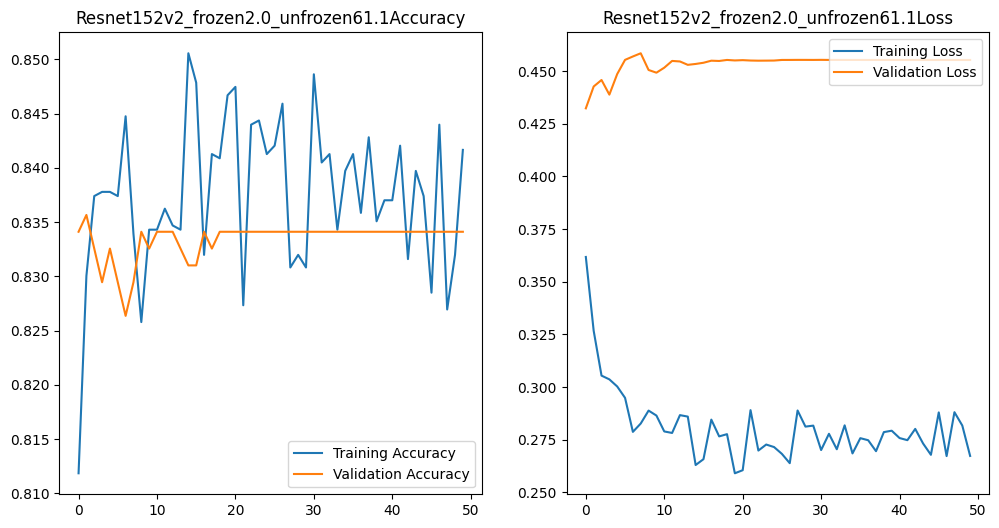

In [ ]:
#Sauvegarde du modèle et des résultats

#Sauvegarde du modèle
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1

model.save('/content/'+ NAME_TO_SAVE + '.keras')

#Export results to dict & csv

#Dump to a pickle file
# Pickle the history to file
filepath = f"{NAME_TO_SAVE}_history.pkl"
filepath = os.path.join(dossier_sauv, filepath)
with open(filepath, 'wb') as f:
    pickle.dump(history, f)

#Impression du schéma
plot_history_metrics(history, NAME_TO_SAVE )

In [ ]:
#Métriques sur jen d'entraînement
best_val_loss_index = np.argmin(history.history["val_loss"])
print("Best validation loss :", round(np.max(history.history["val_loss"]), 2) )
print("Validation ACCURACY : ", round(history.history["val_accuracy"][best_val_loss_index], 2))
print("Obtained at epoch : ", best_val_loss_index + 1)




Best validation loss : 0.46
Validation ACCURACY :  0.83
Obtained at epoch :  1


## 6) Evaluer le modèle sur un jeu de test

In [ ]:
model.load_weights(NAME_TO_SAVE+'.weights.h5')

accuracy = model.evaluate(test_ds, return_dict=True)

print('TEST ACCURACY:',accuracy.get('accuracy'))

101/101 [==============================] - 9s 89ms/step - loss: 0.2158 - accuracy: 0.9275
TEST ACCURACY: 0.9275093078613281
